# DSCI 572 "lecture" 1

Instructor: Mike Gelbart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
plt.rcParams['font.size'] = 16

## Lecture outline:

- Course overview
- Video debrief, True/False (15 min)
- Gradients "review" (30 min)
- Break (5 min)
- True/False (10 min)
- Loss functions (20 min)

## Course overview:

- **first half** (lectures 1-4): "numerical methods" and optimization
- **second half** (lectures 5-8): "deep learning"

The first half of this course departs a bit from the usual MDS style, in that we go into more depth about how machine learning algorithms are implemented. For example, in lab 1 you will implement logistic regression using raw numpy code.

The second half returns to the usual style that you're used to from DSCI 571, etc.

## Video debrief, True/False (15 min)

- The video introduced the idea of optimization, and specifically _continuous_ optimization.
- In DSCI 512 lecture 7 and 8 we talked about _discrete_ optimization.
- Some of the ideas are similar, but the algorithms are completely different.

Optimization (questions based on the pre-class video):

1. Most functions can be minimized using pen and paper, by taking the gradient and then setting it to zero.
2. We are mainly interested in optimizing functions that map a vector to a number ($\mathbb{R}^d \rightarrow \mathbb{R}$).
3. Seam carving (DSCI 512 lab 4) was about _discrete_ optimization; on the other hand, least squares (DSCI 561) involves solving a _continuous_ optimization problem.
4. If an objective function is convex, it only has one global minimum.


<br><br><br><br><br><br><br><br><br><br>

## Gradients/calculus "review"

- I put "review" in quotation marks because some of you may never have seen gradients before.
- Multivariate calculus is not a required prerequisite for the MDS program.
- You don't really need a whole course, just one lecture or so, which we'll try to cover today.
- Here we go:

#### Ingredient 1: functions of multiple variables

- We saw this in DSCI 551 with joint PDFs.
- We can write such a function as $f(x,y,z)$ (for 3 inputs) or $f(x)$ if $x$ is a vector.
- Example: $f(x,y,z) = x^2 + y^2 + e^z + x^z + xyz$.

In [3]:
def f(x, y, z):
    return x**2 + y**2 + np.exp(z) + np.power(x,z) + x*y*z

f(1,2,3)

32.08553692318767

- Another example: $f(x,y) = \sin(xy)$
- We can visualize functions of two variables, but it gets much harder after that.

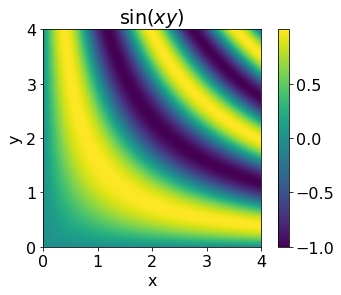

In [4]:
f = lambda x,y: np.sin(x*y)

x = np.linspace(0, 4, 1000)
y = np.linspace(0, 4, 1000)
xx, yy = np.meshgrid(x,y)
zz = f(xx,yy)

plt.imshow(zz,extent=(np.min(x), np.max(x), np.min(y), np.max(y)), origin='lower')
plt.xlabel('x');
plt.ylabel('y');
plt.title('$\sin(xy)$')
plt.colorbar();

#### Ingredient 2: vector-valued functions

- You may not have encountered these yet in MDS.
- These are functions with multiple _outputs_ (and may or may not have multiple _inputs_).
- Example with 1 input and 3 outputs: $$f(x)=\begin{bmatrix} x^2 \\ 2x \\ -x\end{bmatrix}$$
- Example with 3 inputs and 4 outputs: $$f(x,y,z)=\begin{bmatrix} yz^2 \\ 0 \\ xyz \\ x-y\end{bmatrix}$$
- Example with 2 inputs and 2 outputs: $$f(x,y)=\begin{bmatrix} x \\ \sin(y) \end{bmatrix}$$

In [5]:
def f(x,y):
    return np.array([x, np.sin(y)]) 

f(2,10)

array([ 2.        , -0.54402111])

We can visualize functions with two outputs (and two inputs), but it gets much harder after that.

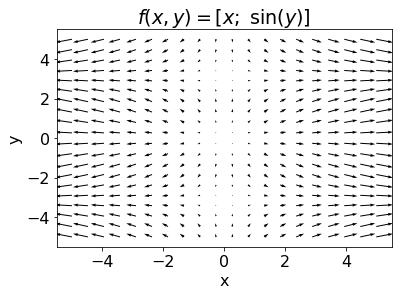

In [6]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
xx, yy = np.meshgrid(x,y)
zz = f(xx,yy)

# plt.imshow(zz,extent=(np.min(x), np.max(x), np.min(y), np.max(y)), origin='lower')
# plt.xlabel('x');
# plt.ylabel('y');
# plt.colorbar();

plt.quiver(xx,yy,zz[0],zz[1]);
# plt.axis('square');
plt.xlabel('x');
plt.ylabel('y');
plt.title('$f(x,y) = [x; \; \sin(y)]$')
plt.show()

Notes:

- For a fixed $y$, when $x$ grows, the $x$-component of the output grows (horizontal length of the arrows)
- A similar argument can be made for $y$.
- It's not always the case that the number of inputs equals the number of outputs - this is a special case!
  - But it's a very important special case, as we'll see below.
  - What it means is that the "input space" and the "output space" are the same.
  - Which allows for this kind of visualization.
- (optional) It's not always the case that the $i$th component of the output depends on the $i$th component of the inputs - this is also a special case!

#### Ingredient 3: partial derivatives

- A partial derivative is just a derivative of a multivariable function with respect to one of the input variables.
- When taking this derivative, we treat all the other variables as constants.
  - See [partial derivative slide](partial-deriv.pdf).
- Example: let $f(x,y,z) = x^2 + y^2 + e^x + x^z + xyz$, let's compute $\frac{\partial}{\partial x} f(x,y,z)$

$$\begin{align}\frac{\partial}{\partial x} \quad &x^2 &+ \quad &y^2 &+ \quad &e^x &+ \quad &x^z &+ \quad &xyz\\=\quad &2x &+ \quad &0 &+\quad  &e^x &+ \quad &zx^{z-1} &+ \quad &yz\end{align}$$

- **Important note**: $\frac{\partial f}{\partial x} $ is itself a function of $x,y,z$, not just a function of $x$. Think about the picture from the PDF slide above: the slope depends on your position in all coordinates.
- (optional) Thus, the partial derivative operator $\frac{\partial}{\partial x}$ maps from multivariate functions to multivariable functions.

#### Ingredient 4: gradients

- This is the easy part: a gradient is just a box holding all the $d$ partial derivatives (assuming you have a function of $d$ variables). For example, when $d=3$:
 
$$\nabla f(x,y,z)=\begin{bmatrix}\frac{\partial f}{\partial x}(x,y,z)\\ \frac{\partial f}{\partial y}(x,y,z) \\\frac{\partial f}{\partial z}(x,y,z)\end{bmatrix}$$

Or, more generally, if $x$ is a vector then

$$\nabla f(x)=\begin{bmatrix}\frac{\partial f}{\partial x_1}(x)\\ \frac{\partial f}{\partial x_2}(x) \\ \vdots \\ \frac{\partial f}{\partial x_d}(x)\end{bmatrix}$$


- (optional) Thus, a partial derivative is a function that has the same mapping as the original, e.g. $\mathbb{R}^3\rightarrow \mathbb{R}$ ("R three to R").
- (optional) a gradient is a function that maps from the original input space to the same space, e.g. $\mathbb{R}^3\rightarrow \mathbb{R}^3$ ("R three to R three").

**Notation warning**: we use the term "derivative" or "gradient" to mean three different things:

1. Operator (written $\frac{d}{dx}$ or $\nabla$), which maps **functions to functions**; "now we take the gradient".
2. Function (written $\frac{df}{dx}$ or $\nabla f$), which maps **vectors to vectors**; "the gradient is $2x+5$"
  - This is what you get after applying the operator to a function.
3. Value (written as a number or vector), which is **just a number or vector**; "the gradient is  $\begin{bmatrix}-2.34\\6.43\end{bmatrix}$"
  - This is what you get after applying the function to an input.
  
This is extremely confusing!

Here's a table summarizing the situation, assuming 3 variables (in general it could be any number)

|  Name   | Operator | Function | Maps  | Example Value  |
|---------|----------|-----------|------|----------|
| Derivative | $\frac{d}{dx}$ | $\frac{df}{dx}(x)$ | $\mathbb{R}\rightarrow \mathbb{R}$ | $2.5$ |
| Partial Derivative |  ${\frac{\partial}{\partial x}}$ |  ${\frac{\partial f}{\partial x}}(x,y,z)$ | ${\mathbb{R}^3\rightarrow \mathbb{R}}$ | $2.5$ |
| Gradient |  $\nabla$ | $\nabla f(x,y,z)$ |$\mathbb{R}^3\rightarrow \mathbb{R}^3$ | $\begin{bmatrix}2.5\\0\\-1\end{bmatrix}$ |

#### Gradients intuition

Since a gradient is a vector, we can talk about its magnitude and direction.
  - The magnitude is $\|\nabla f\|$ and tells us **how fast things are changing**.
  - The direction is $\frac{\nabla f}{\|\nabla f \|}$ and tells us **the direction of fastest change** or the steepest direction.

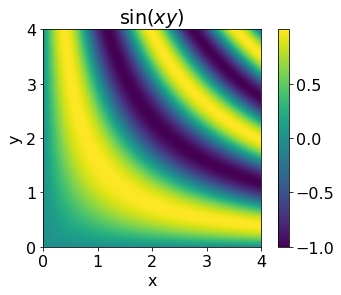

In [7]:
# gradient vector field
f = lambda x,y: np.sin(x*y)

x = np.linspace(0, 4, 1000)
y = np.linspace(0, 4, 1000)
xx, yy = np.meshgrid(x,y)
zz = f(xx,yy)

plt.imshow(zz,extent=(np.min(x), np.max(x), np.min(y), np.max(y)), origin='lower')
plt.xlabel('x');
plt.ylabel('y');
plt.title('$\sin(xy)$')
plt.colorbar();

$$\nabla \sin(xy) = \begin{bmatrix} y \cos(xy)\\x\cos(xy)\end{bmatrix}$$

In [8]:
gradf = lambda x,y: (y*np.cos(x*y),x*np.cos(x*y))

xsmall = np.linspace(0, 4, 15)
ysmall = np.linspace(0, 4, 15)
xxsmall, yysmall = np.meshgrid(xsmall,ysmall)
gradx, grady = gradf(xxsmall,yysmall)

# plt.imshow(zz,extent=(np.min(x), np.max(x), np.min(y), np.max(y)), origin='lower')
# plt.xlabel("$x$")
# plt.ylabel("$y$")
# plt.title("∇$ \sin(xy)$")
# plt.colorbar();

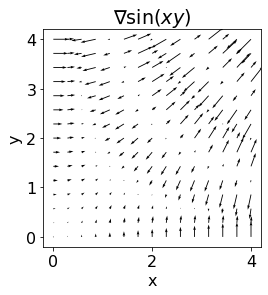

In [9]:
plt.quiver(xxsmall,yysmall,gradx,grady);
plt.axis('square');
plt.xlabel("x")
plt.ylabel("y")
plt.title("∇$ \sin(xy)$");

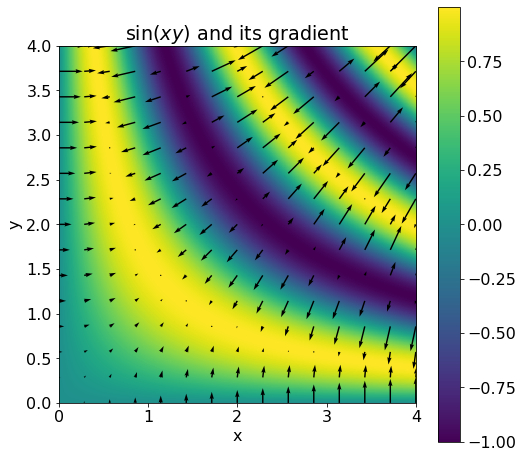

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(zz,extent=(np.min(x), np.max(x), np.min(y), np.max(y)), origin='lower')
plt.colorbar();
plt.quiver(xxsmall,yysmall,gradx,grady);
plt.xlabel("x")
plt.ylabel("y")
plt.title("$\sin(xy)$ and its gradient");

#### (optional) Why is it the direction of fastest increase?

For example if the gradient is $$\begin{bmatrix} 5 \\ 2 \\ -1 \\ 0 \end{bmatrix}\, ,$$

why go in the gradient direction instead of the $x_1$ direction, since that first component has the biggest partial derivative. Doesn't it seem wasteful to go partly in those other directions?

First, a proof that the gradient is the best direction. Let's say we are at position $x$ and we move by an infinitesimal (i.e. extremely tiny) $v$, which is a vector having components $v_1, v_2, \ldots v_d$. The change in $f$ from moving from $x$ to $x+v$ is $\frac{\partial f}{dx_1} v_1 + \frac{\partial f}{dx_2} v_2 + \ldots \frac{\partial f}{dx_d} v_d$, where all the partial derivatives are evaluated at $x$ (I believe this is related to the "total derivative"). In other words, the change in $f$ is the dot product $\nabla f \cdot v$. So now the question is, what vector $v$ of fixed length maximizes $\nabla f \cdot v$. The answer is a vector that points in the same direction as $\nabla f$. (That's a property of the dot product, and is evident by the definition: $a \cdot b = \| a \| \|b \| \cos(\theta)$. Since $\| \nabla f \|$ and $\|v\|$ are fixed in our case, to maximize this we want to maximize $\cos(\theta)$, which means we want $\cos(\theta)=1$ meaning $\theta=0$, or the angle between the vectors is $0$).

Second, the intuition. I think the "paradox" comes from over-privileging the coordinate axes. They are not special in any way! For example if you rotate the coordinate system by 45 degrees, the direction of steepest ascent should also rotate by 45 degrees. Under the suggested system, this would not happen. Why? Well, there is always going to be one element of the gradient that is largest. Does that mean the direction of steepest ascent is always one of the coordinate axis directions? No. That doesn't make sense and also fails the "rotate by 45 degrees test" because the direction will have rotated by 0, 90, 180 or 270 degrees.


## Break (5 min)

## Gradients True/false questions (10 min)

1. The gradient of a one-variable function is the same thing as the derivative of the function.
2. If we multiply a function by a constant, its gradient gets multiplied by that constant; in symbols, $\nabla (a \cdot f(x)) = a \,\nabla f(x)$
3. If one element of a gradient is zero, then all the elements must be zero.
4. If all the elements of the gradient at $x$ are negative, the function is decreasing at $x$.

<br><br><br><br><br><br><br><br>

## Loss functions (20 min)

- You have seen least squares for linear regression:

$$\min_w \sum_{i=1}^n \left(w^Tx_i - y_i\right)^2$$

- (Note: we will use $w$ instead of $\beta$ for the regression coefficients / weights.)
- This function that we're minimizing is called the **loss function**.

#### Example: robust linear regression

- An example of a different loss function would be the absolute value loss:

$$\min_w \sum_{i=1}^n \left| w^Tx_i - y_i \right|$$

- What are the implications of switching between these different choices? 


In [11]:
def lr_loss_squared(w, X, y):
    return np.sum((X@w-y)**2)

In [12]:
def lr_loss_abs(w, X, y):
    return np.sum(np.abs(X@w-y))

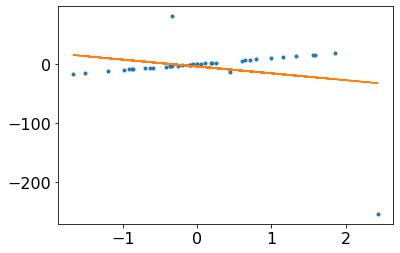

In [13]:
def gen_outlier_data(n=40,Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    y = 10*x
    # add random outliers
    y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

    X = x[:,None] # reshape for sklearn

    return X,y

np.random.seed(5)

X,y = gen_outlier_data()
lr = LinearRegression()
lr.fit(X,y)

plt.plot(X,y,'.')
plt.plot(X, lr.predict(X));

In [14]:
X_1 = np.concatenate((X, np.ones(X.shape)),axis=1)

In [15]:
w_min = minimize(lr_loss_squared, np.zeros(2), args=(X_1, y)).x

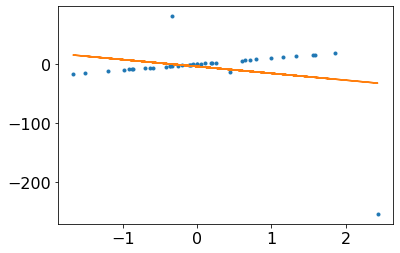

In [16]:
plt.plot(X,y,'.')
plt.plot(X, X_1@w_min);

In [17]:
w_min_abs = minimize(lr_loss_abs, np.zeros(2), args=(X_1, y)).x # don't try this at home

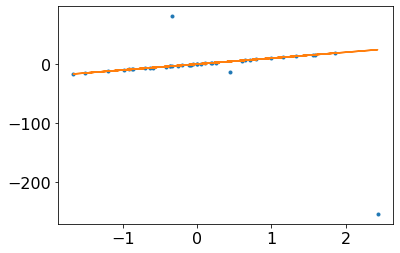

In [18]:
plt.plot(X,y,'.')
plt.plot(X, X_1@w_min_abs);

- So, it seems like we got very diffrent fits by changing the loss function.
- In this case, the absolute loss gave us robust regression.
- The loss function is important!

### Aside: an interpretation of the mean and median

- The mean is the number that minimizes the squared loss between itself and the set of numbers.
- The median is the number that minimizes the absolute loss between itself and the set of numbers.

So if you believe the median is more robust than the mean, you should believe the absolute value loss is more robust than the squared loss.

In [19]:
nums = np.array([1,7,4,-3,3.4,100,50])

print("Mean of the numbers:", np.mean(nums))
print("Median of the numbers:", np.median(nums))

Mean of the numbers: 23.2
Median of the numbers: 4.0


In [32]:
squared_loss = lambda x: np.sum(np.square(x-nums))
print("Value the minimizes the squared distance from the numbers:", minimize(squared_loss, 0).x)

Value the minimizes the squared distance from the numbers: [23.19999869]


In [33]:
absolute_loss = lambda x: np.sum(np.abs(x-nums))
print("Value the minimizes the absolute value distance from the numbers:", minimize(absolute_loss, 0).x)

Value the minimizes the absolute value distance from the numbers: [3.99999999]


### Back to the big picture

We can start to think of (a lot of) ML as a 3-step process:

1. Choose your model
2. Choose your loss function
3. Choose your optimization algorithm

What do these do?

1. The model controls the space of possible functions from $X$ to $y$.
  - For example, a linear model can only learn linear functions.
2. The loss function tells us how to compare these various functions.
  - For example, is $y=2x_1+3x_2$ a better model than $y=10x_1-x_2$?
3. The optimization algorithm computationally finds the minimum of the loss function.
  - We'll talk about this next class and next week.

#### Loss function example: logistic regression vs. SVM

In [22]:
n = 100
d = 2

X = np.random.rand(n,d)
y = np.random.choice((-1,+1), size=n, replace=True)
X[y==1,0] += .5

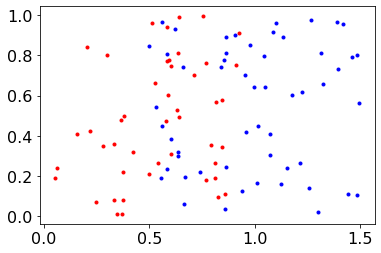

In [23]:
plt.plot(X[y==-1,0], X[y==-1,1], '.r')
plt.plot(X[y==1,0], X[y==1,1], '.b');

In [24]:
y = y[:,None]

In [25]:
def plot_loss_2d(loss_fun, title='', nw1=100, nw2=100):
    wmin = -5
    wmax = 5
    w1_lin = np.linspace(wmin, wmax, nw1)
    w2_lin = np.linspace(wmin, wmax, nw2)
    w1_grid, w2_grid = np.meshgrid(w1_lin,w2_lin)

    w1_flat = w1_grid.flatten()
    w2_flat = w2_grid.flatten()

    W = np.concatenate((w1_flat[None], w2_flat[None]), axis=0)
    
    loss_flat = loss_fun(W, X, y)
    loss_grid = np.reshape(loss_flat, (nw1,nw2))

#     plt.imshow(loss_grid, extent=(np.min(w1_lin), np.max(w1_lin), np.min(w2_lin), np.max(w2_lin)), origin='lower')
    CS = plt.contour(w1_grid, w2_grid, loss_grid, levels=20)

    imin = np.argmin(loss_grid)
    plt.plot(w1_flat[imin], w2_flat[imin], 'r*', markersize=15)

    plt.xlabel('$w_1$');
    plt.ylabel('$w_2$');
    plt.title(title)
#     plt.colorbar();


- Logistic regression are both linear classifiers, but they use different loss functions.
- You saw in DSCI 571 that these differences have some implications, like the idea of "support vectors".
- We can visulalize these loss functions below:

In [26]:
def loss_lr(w, X, y, λ=1e-3):
    return np.sum(np.log(1 + np.exp(-y*(X@w))),axis=0) + λ*np.sum(w**2,axis=0)

def loss_svm(w, X, y, λ=1e-3):
    return np.sum(np.maximum(0,1-y*(X@w)),axis=0) + λ*np.sum(w**2,axis=0)

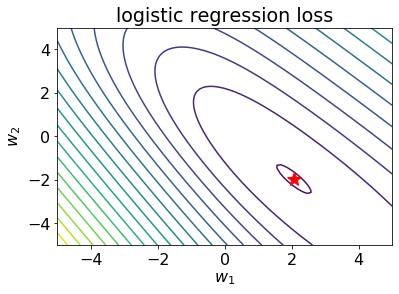

In [27]:
plot_loss_2d(loss_lr, "logistic regression loss")

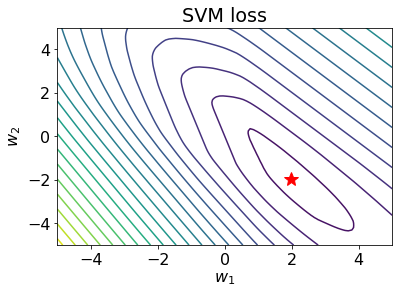

In [28]:
plot_loss_2d(loss_svm, "SVM loss")

- In practice, we need to use different methods to minimize these functions, because the SVM loss is non-smooth.
- However, that is beyond the scope of the course.
- We can see more of the non-smoothness below if we take a vertical slice of these 2d contour plots.

In [29]:
def plot_loss_1d(loss_fun, title='', w1=0):
    w2_grid = np.linspace(-5,5,5000)
    w = np.zeros((2,len(w2_grid)))
    w[1] = w2_grid # vary w2
    w[0] = w1
    loss_slice = loss_fun(w, X, y)
    plt.plot(w2_grid, loss_slice)
    plt.xlabel("$w_2$")
    plt.ylabel("loss")
    plt.title(title);

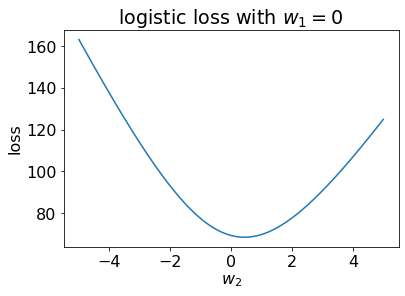

In [30]:
plot_loss_1d(loss_lr, "logistic loss with $w_1=0$")

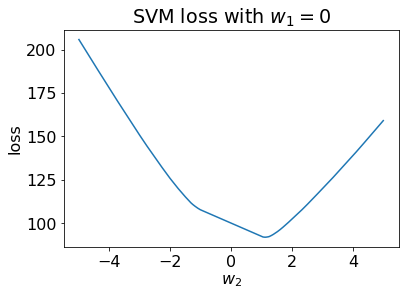

In [31]:
plot_loss_1d(loss_svm, "SVM loss with $w_1=0$");